<a href="https://colab.research.google.com/github/Ziad-o-Yusef/Vision-Transformers-Code/blob/main/Vision_Transformers_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets
! pip install accelerate -U
! pip install transformers[torch]
! pip show transformers
! pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import os
import cv2
import numpy as np
import datasets
import torch
from google.colab import drive
import matplotlib.pyplot as plt
from datasets import load_metric
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from datasets import load_metric
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle_MyAPI'

In [ ]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

 94% 358M/380M [00:04<00:00, 98.6MB/s]
100% 380M/380M [00:04<00:00, 90.7MB/s]


In [ ]:
! unzip /content/augmented-alzheimer-mri-dataset.zip

In [ ]:

Oreginal_dir = '/content/AugmentedAlzheimerDataset'
lables = os.listdir(Oreginal_dir)
train_dir = '/content/TrainData'
test_dir = '/content/TestData'
lst_od_dirs = [train_dir,test_dir]
persintage = .25
train_p = 0
im_size = (200, 190)


os.makedirs(train_dir)
os.makedirs(test_dir)


for i in lst_od_dirs:
  for j in lables:
    os.makedirs(i + '/' + j)

for i in lables:
  data = os.listdir(Oreginal_dir + '/' + i)
  hund_per = len(data)
  train_p = round(hund_per * (1- persintage))

  for idx in range(0,train_p):
    img_dir = Oreginal_dir + '/' + i + '/' + data[idx]
    new_im_dir = train_dir + '/' + i + '/' + data[idx]
    im_read = cv2.imread(img_dir)
    im_read = cv2.resize(im_read,im_size )
    cv2.imwrite(new_im_dir,im_read )

  for idx in range(train_p,hund_per):
    img_dir = Oreginal_dir + '/' + i + '/' + data[idx]
    new_im_dir = test_dir + '/' + i + '/' + data[idx]
    im_read = cv2.imread(img_dir)
    cv2.imwrite( new_im_dir,im_read)



In [ ]:
len(os.listdir('/content/TestData/MildDemented')),len(os.listdir('/content/TrainData/MildDemented'))

(2240, 6720)

In [ ]:
len(os.listdir('/content/TestData/MildDemented')) + len(os.listdir('/content/TrainData/MildDemented')),len(os.listdir('/content/AugmentedAlzheimerDataset/MildDemented'))

(8960, 8960)

In [ ]:
imshow_dirs = []

In [ ]:
dir = "/content/AugmentedAlzheimerDataset"
dirs = os.listdir(dir)
for i in dirs :
    step = os.listdir(dir+ '/'+ i)
    imshow_dirs.append(dir+ '/' + i + '/' + step[3])
print(len(imshow_dirs))

24


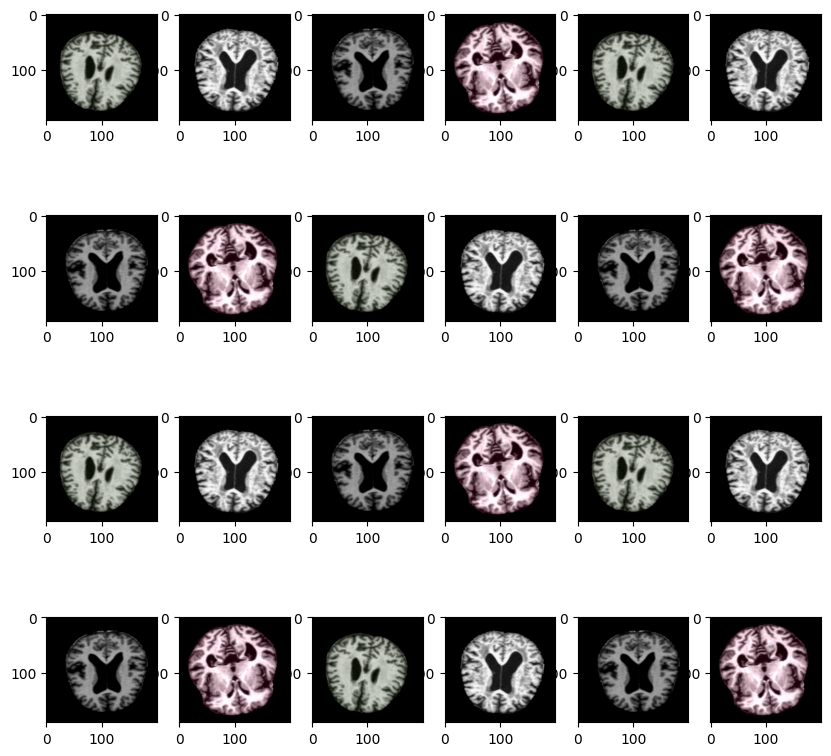

In [ ]:
fig, ax = plt.subplots(4,6,figsize=(10,10))
for n in range(4):
    for m in range(6):
        path =imshow_dirs[m + 6*n]
        image = cv2.imread(str(path))
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [ ]:
" Modiling Functions "

def model_processor(model_name,Vit_or_Auto):
  if Vit_or_Auto == 'vit':
    processor = ViTImageProcessor.from_pretrained(model_name)
    return processor
  elif Vit_or_Auto ==  'auto':
    processor =  AutoImageProcessor.from_pretrained(model_name)
    return processor


def transform(data):
    inputs = processor([x for x in data['image']], return_tensors='pt')

    inputs['labels'] = data['label']
    return inputs


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


def Model(model_name,num_labels,id2label,label2id,WithInfo,Vit_or_Auto):
  if Vit_or_Auto == 'vit':
    if WithInfo:
      return  ViTForImageClassification.from_pretrained(
      model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,)
    else:
      return  ViTForImageClassification.from_pretrained(
      model_name,)
  elif Vit_or_Auto == 'auto':
    return AutoModelForImageClassification.from_pretrained(model_name)


def training_args(output_dir,num_train_epochs):

    return TrainingArguments(
  output_dir=output_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs= num_train_epochs,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
 report_to='tensorboard',
  load_best_model_at_end=True,)



def compute_metrics(p):
    metric = load_metric("accuracy")
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


def Training_func(model,training_args,collate_fnm,compute_metrics,train_dataset,eval_dataset,tokenizer):
    return Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

In [ ]:
train_dataset = datasets.load_dataset("imagefolder", data_dir="/content/TrainData")
test_dataset = datasets.load_dataset("imagefolder", data_dir="/content/TestData")


Resolving data files:   0%|          | 0/25488 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/8496 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25488
    })
})

In [ ]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8496
    })
})

In [ ]:

processor = model_processor('google/vit-base-patch16-224-in21k','vit')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)


labels = os.listdir('/content/AugmentedAlzheimerDataset')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

model_4 = Model('google/vit-base-patch16-224-in21k',len(labels),id2label,label2id,True,'vit')

model_4_training_args = training_args("./vit-task_2",2)

training_cat = Training_func(model_4,model_4_training_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results_4 = training_cat.train()
training_cat.log_metrics("train", train_results_4.metrics)
training_cat.save_metrics("train", train_results_4.metrics)
training_cat.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,1.193500,1.308380,0.459157
200,0.843100,0.869899,0.562500
300,0.831100,0.933860,0.574859
400,0.744500,0.732428,0.665372
500,0.600400,0.700743,0.665607
600,0.637600,0.647555,0.701860
700,0.713500,0.731769,0.656191
800,0.541700,0.658799,0.688559
900,0.548500,0.559134,0.757298
1000,0.567700,0.668815,0.701153


***** train metrics *****
  epoch                    =          2.0
  total_flos               = 3679005868GF
  train_loss               =       0.4181
  train_runtime            =   1:52:38.87
  train_samples_per_second =        7.542
  train_steps_per_second   =        0.471


In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9464
  eval_loss               =     0.1598
  eval_runtime            = 0:02:24.25
  eval_samples_per_second =     58.895
  eval_steps_per_second   =      7.362


In [ ]:
processor = model_processor('facebook/deit-small-patch16-224','vit')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)

labels = os.listdir('/content/AugmentedAlzheimerDataset')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

model_4 = Model('facebook/deit-small-patch16-224',len(labels),id2label,label2id,False,'vit')
model_4_training_args = training_args("./vit-task_2",3)

training_cat = Training_func(model_4,model_4_training_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)

In [ ]:
train_results_4 = training_cat.train()
training_cat.log_metrics("train", train_results_4.metrics)
training_cat.save_metrics("train", train_results_4.metrics)
training_cat.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,1.129100,1.107412,0.506709
200,0.948000,0.870007,0.594633
300,0.966400,0.860677,0.596163
400,0.729700,0.866980,0.606638
500,0.712700,0.934022,0.606756
600,0.663200,0.758974,0.658427
700,0.724500,0.675178,0.683851
800,0.597400,0.640291,0.709040
900,0.594300,0.606754,0.719162
1000,0.644500,0.756695,0.656544


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 1418232249GF
  train_loss               =       0.3683
  train_runtime            =   1:32:30.15
  train_samples_per_second =       13.777
  train_steps_per_second   =        0.861


In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9542
  eval_loss               =     0.1767
  eval_runtime            = 0:01:36.09
  eval_samples_per_second =     88.413
  eval_steps_per_second   =     11.052


In [ ]:
processor = model_processor('microsoft/beit-base-patch16-224-pt22k-ft22k','auto')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)

labels = os.listdir('/content/AugmentedAlzheimerDataset')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

model_4 = Model('microsoft/beit-base-patch16-224-pt22k-ft22k',len(labels),id2label,label2id,False,'auto')
model_4_training_args = training_args("./vit-task_2",2)

training_cat = Training_func(model_4,model_4_training_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results_4 = training_cat.train()
training_cat.log_metrics("train", train_results_4.metrics)
training_cat.save_metrics("train", train_results_4.metrics)
training_cat.save_state()

In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)